# ch04.07 Variational AutoEncoder

* 날짜: 2022-09-02
* 이름: 고민수

## 학습내용
    - Variational AutoEncoder를 이해하고 구현한다.


In [32]:
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')
import set_matplotlib_hangul


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

Hangul OK in your window!


## VAE 기본 구현
---

![](https://user-images.githubusercontent.com/24144491/50323466-18d03700-051d-11e9-82ed-afb1b6e2666a.png)

### **| Encoder, Decoder 구현**

In [7]:
class Sampling(layers.Layer):  # 상속

    def call(self, inputs):
        z_mu, z_sigma = inputs
        z_epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mu))
        z = (tf.exp(z_epsilon * 0.5) * z_sigma) + z_mu
        return z


class BuildModel():

    def __init__(self, x_shape=(28, 28, 1), z_dims=100):
        self.x_shape = x_shape
        self.z_dims = z_dims

    def build_encoder(self):
        x = layers.Input(shape=self.x_shape)
        z = layers.Conv2D(32,
                          3,
                          strides=2,
                          padding='same',
                          activation='leaky_relu')(x)
        z = layers.Conv2D(32,
                          3,
                          strides=2,
                          padding='same',
                          activation='leaky_relu')(z)
        self.z_conv_shape = z.shape[1:]  # (7, 7, 32)

        z = layers.Flatten()(z)
        z_mu = layers.Dense(z_dims, activation='relu')(z)
        z_sigma = layers.Dense(z_dims, activation='relu')(z)

        z = Sampling()([z_mu, z_sigma])
        encoder = models.Model(x, [z_mu, z_sigma, z], name='Encoder')
        return encoder

    def build_decoder(self):
        z = layers.Input(shape=self.z_dims)
        y = layers.Dense(256, activation='relu')(z)
        dim = self.z_conv_shape[0] * self.z_conv_shape[1] * self.z_conv_shape[2]
        y = layers.Dense(dim, activation='relu')(y)
        y = layers.Reshape(self.z_conv_shape)(y)
        y = layers.Conv2DTranspose(32,
                                   3,
                                   strides=2,
                                   padding='same',
                                   activation='leaky_relu')(y)
        y = layers.Conv2DTranspose(1,
                                   3,
                                   strides=2,
                                   padding='same',
                                   activation='sigmoid')(y)

        decoder = models.Model(z, y, name='Decoder')
        return decoder

In [8]:
x_shape = (28,28,1)
z_dims = 10
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()
encoder.summary()
decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 32)     9248        ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 1568)         0           ['conv2d_3[0][0]']               
                                                                                            

### **| 손실함수 정의**

![](https://user-images.githubusercontent.com/24144491/50323472-1a016400-051d-11e9-86b7-d8bf6a1a880f.png)

In [9]:
'''loss.py'''
def get_rec_loss(imgs, recs):
    rec_loss = tf.keras.losses.binary_crossentropy(imgs, recs)
    rec_loss = tf.reduce_mean(rec_loss)
    return rec_loss


def get_kl_loss(z_mu, z_sigma):
    kl_loss = tf.square(z_mu) + (tf.exp(z_sigma) - z_sigma - 1)
    kl_loss = 0.5 * tf.reduce_mean(kl_loss)
    return kl_loss

### **| VAE 구현**

In [10]:
class VAE():
    def __init__(self, encoder, decoder, x_shape):
        self.encoder = encoder
        self.decoder = decoder
        self.x_shape = x_shape

    def compile(self, optimizer=tf.keras.optimizers.Adam()):
        img = layers.Input(shape=x_shape)
        z_mu, z_sigma, z = self.encoder(img)
        rec = self.decoder(z)

        self.vae = models.Model(img, rec, name='VAE')
        self.optimizer = optimizer

    @tf.function
    def train_step(self, imgs):
        # imgs.shape = (16, 28, 28, 1)
        with tf.GradientTape() as tape:

            # propagation
            z_mu, z_sigma, z = self.encoder(imgs)
            recs = self.decoder(z)

            # loss 계산 - (rec loss / kl loss)
            rec_loss = get_rec_loss(imgs,
                                    recs)  # 원본 이미지와 재구성한 이미지가 최대한 비슷해지면 좋겠다
            kl_loss = get_kl_loss(z_mu, z_sigma)  # z가 다양하면서, 정보량 유사
            loss = rec_loss + kl_loss

        # gradient 계산
        weights = self.vae.trainable_variables
        gradients = tape.gradient(loss, weights)

        # weight 업데이트
        self.optimizer.apply_gradients(zip(gradients, weights))

        return loss, rec_loss, kl_loss

    def fit(self, x_data, epochs=1, batch_size=16):

        train_ds = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)
        self.batch_size = batch_size
        history = {
            'loss': [0 for i in range(epochs)],
            'rec_loss': [0 for i in range(epochs)],
            'kl_loss': [0 for i in range(epochs)]
        }

        for epoch in range(1, epochs + 1):
            self.epoch = epoch
            for imgs in train_ds:
                loss, rec_loss, kl_loss = self.train_step(imgs)
                loss, rec_loss, kl_loss = loss.numpy(), rec_loss.numpy(
                ), kl_loss.numpy()
                history['loss'][epoch - 1] += loss
                history['rec_loss'][epoch - 1] += rec_loss
                history['kl_loss'][epoch - 1] += kl_loss

            print(
                f"* [ {epoch} / {epochs}]  loss: {history['loss'][epoch-1]} rec_loss: {history['rec_loss'][epoch-1]} kl_loss: {history['kl_loss'][epoch-1]}"
            )
            self.plot_sample_imgs(imgs)

    def plot_sample_imgs(self, imgs, n=10):
        plt.figure(figsize=(n, 2))
        rec_imgs = self.vae.predict(imgs[:n])
        for i, (img, rec_img) in enumerate(zip(imgs, rec_imgs)):
            plt.subplot(2, n, i + 1)
            plt.imshow(np.squeeze(img), cmap='gray_r')
            plt.axis('off')
            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.squeeze(rec_img), cmap='gray_r')
            plt.axis('off')
        plt.show()

### **| 학습**

In [11]:
def get_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float32) / 255
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.astype(np.float32) / 255
    x_test = x_test.reshape(-1, 28, 28, 1)

    return x_train, x_test

In [14]:
x_train, x_test = get_mnist()
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [15]:
x_shape = (28,28,1)
z_dims = 100
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()

vae = VAE(encoder, decoder, x_shape)
vae.compile()
vae.vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 100),             323368    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         438369    
                                                                 
Total params: 761,737
Trainable params: 761,737
Non-trainable params: 0
_________________________________________________________________


* [ 1 / 5]  loss: 311.1108691804111 rec_loss: 306.7576712779701 kl_loss: 4.353198098368011
1/1 [==============================] - 0s 148ms/step


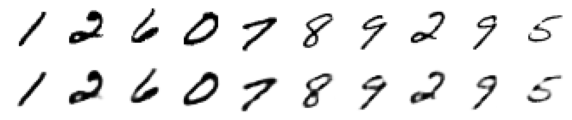

* [ 2 / 5]  loss: 288.344798527658 rec_loss: 285.2834166176617 kl_loss: 3.0613820303115062
1/1 [==============================] - 0s 12ms/step


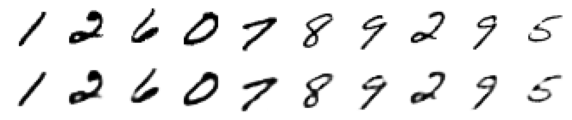

* [ 3 / 5]  loss: 278.5109134539962 rec_loss: 275.954893887043 kl_loss: 2.5560196060396265
1/1 [==============================] - 0s 13ms/step


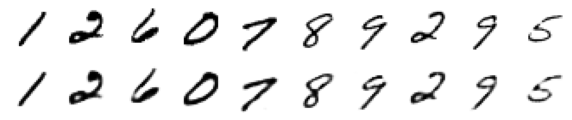

* [ 4 / 5]  loss: 272.8914474211633 rec_loss: 270.5827006921172 kl_loss: 2.3087466028810013
1/1 [==============================] - 0s 12ms/step


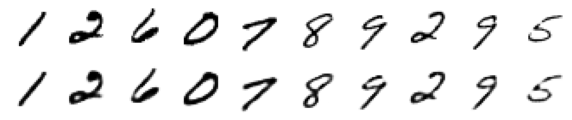

* [ 5 / 5]  loss: 269.0463189072907 rec_loss: 266.8861817084253 kl_loss: 2.1601371802098583
1/1 [==============================] - 0s 12ms/step


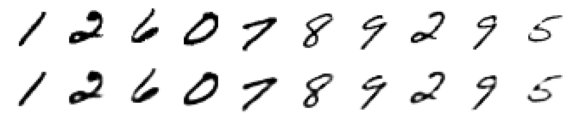

In [17]:
import matplotlib.pyplot as plt

vae.fit(x_train, 5)

### **| 결과 확인**

## 새소리 클러스터링
---

In [18]:
! git clone https://github.com/yebiny/Songbird-clusturing.git

Cloning into 'Songbird-clusturing'...


In [20]:
import sys
sys.path.append('./Songbird-clusturing/data_process')
from syllable_generator import *
from draw_tools import *

In [21]:
gen = SyllableGenerator('D:Dataset/dataset/bird_sound_wav/')

In [22]:
gen.wav_list

['D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_100953_641.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_100956_441.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_103140_478.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_103142_843.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_103144_435.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_103224_961.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_104922_885.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_104927_155.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_104942_424.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_112708_610.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_112731_559.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_114105_931.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_114108_571.wav',
 'D:Dataset/dataset/bird_sound_wav\\w58y67_20200428_114115_693.wav',
 'D:Dataset/dataset/bird_sound_wav

D:Dataset/dataset/bird_sound_wav\w58y67_20200428_100953_641.wav


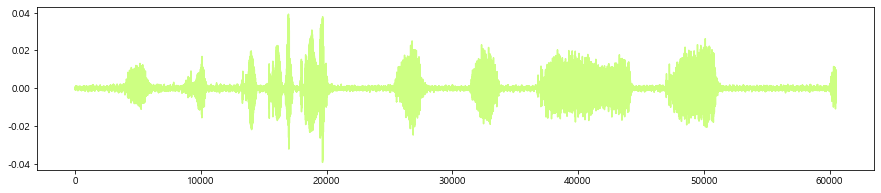

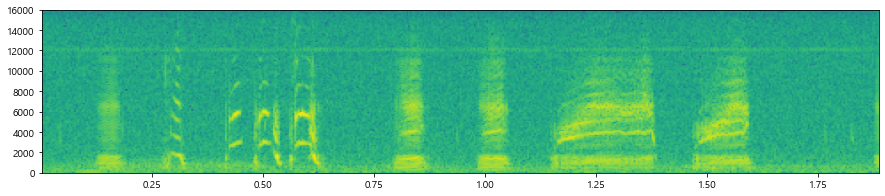

In [33]:
idx = 0
wav = gen.wav_list[idx]
print(wav)

draw_wav(wav)
draw_spectrogram(wav)

In [34]:
syllables = gen.get_syllable_list(gen.wav_list)

* Finish Idx 0 wav file :  bird_sound_wav\w58y67_20200428_100953_641
* Finish Idx 10 wav file :  bird_sound_wav\w58y67_20200428_112731_559
* Finish Idx 20 wav file :  bird_sound_wav\w58y67_20200428_115428_195
* Finish Idx 30 wav file :  bird_sound_wav\w58y67_20200428_115802_306
* Finish Idx 40 wav file :  bird_sound_wav\w58y67_20200428_115916_607
* Finish Idx 50 wav file :  bird_sound_wav\w58y67_20200428_120203_663


In [35]:
print(syllables.shape)
print(' idx  startPoint  length')
print(syllables[:3])

wav_idx = syllables[:, 0]
start_point = syllables[:,1]
length = syllables[:,2]

(765, 3)
 idx  startPoint  length
[[    0  3891  2001]
 [    0  8697  1882]
 [    0 13002  1608]]


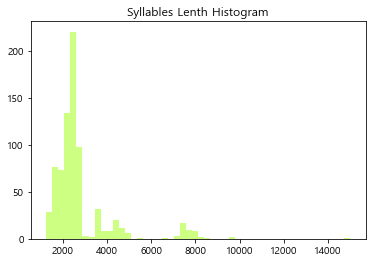

In [36]:
hist_syllable_lenth(length)

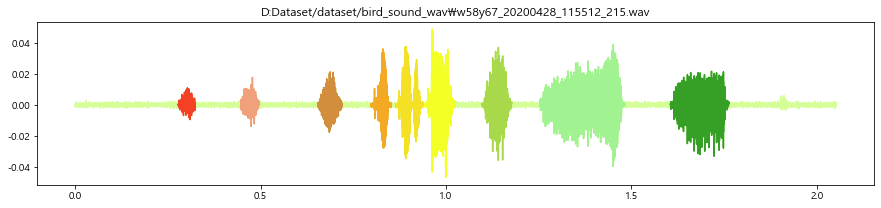

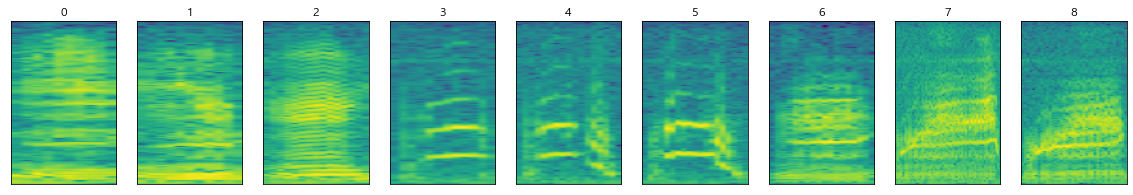

In [37]:
idx = 26
draw_split_wav(gen.wav_list, syllables, idx)
draw_split_spectrogram(gen.wav_list, syllables, idx)

In [38]:
from data_process import *

dp = DataProcess(gen.wav_list, syllables)

ys, imgs = dp.get_dataset()
ys.shape, imgs.shape

* Start process...  total syllables: 765
0
100
200
300
400
500
600
700


((765,), (765, 128, 64))

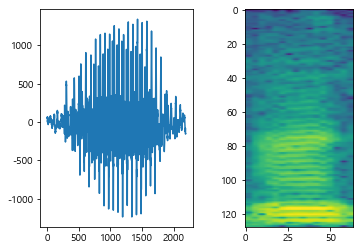

In [39]:
plt.subplot(121); plt.plot(ys[idx])
plt.subplot(122); plt.imshow(imgs[idx])

(765, 128, 64, 1)

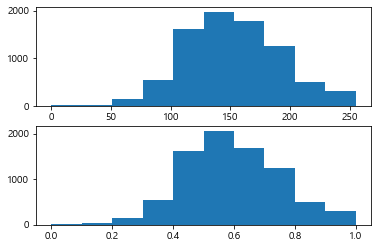

In [40]:
x_data = imgs / 255.
x_data = np.expand_dims(x_data, 3)
plt.subplot(211);plt.hist(imgs[0].flatten())
plt.subplot(212);plt.hist(x_data[0].flatten())
x_data.shape

In [49]:
np.save('./tmp/pre/x_train', x_data)
np.save('./tmp/pre/x_test', x_data)

In [45]:
sys.path.append('./Songbird-clusturing/2-Train')
from trainVAE_ver1 import *

In [51]:
z_dims = 2
data_path = './tmp/' 
save_path = './tmp/result'
vae = TrainVAE(z_dims, data_path, save_path)
vae.vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 64, 1)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               357284    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 64, 1)        357761    
                                                                 
Total params: 715,045
Trainable params: 715,045
Non-trainable params: 0
_________________________________________________________________


In [52]:
vae.train(1000, 4)

* 0 * loss: 5464.237793,  best_loss: 5464.237793, l_rate: 0.001000, lr_count: 0
* 1 * loss: 5333.326660,  best_loss: 5333.326660, l_rate: 0.001000, lr_count: 0
* 2 * loss: 5286.277344,  best_loss: 5286.277344, l_rate: 0.001000, lr_count: 0
* 3 * loss: 5276.854980,  best_loss: 5276.854980, l_rate: 0.001000, lr_count: 0
* 4 * loss: 5267.041016,  best_loss: 5267.041016, l_rate: 0.001000, lr_count: 0
* 5 * loss: 5258.520020,  best_loss: 5258.520020, l_rate: 0.001000, lr_count: 0
* 6 * loss: 5254.127441,  best_loss: 5254.127441, l_rate: 0.001000, lr_count: 0
* 7 * loss: 5248.013184,  best_loss: 5248.013184, l_rate: 0.001000, lr_count: 0
* 8 * loss: 5248.074707,  best_loss: 5248.013184, l_rate: 0.001000, lr_count: 0
* 9 * loss: 5240.949219,  best_loss: 5240.949219, l_rate: 0.001000, lr_count: 0
* 10 * loss: 5238.756348,  best_loss: 5238.756348, l_rate: 0.001000, lr_count: 0
* 11 * loss: 5240.469238,  best_loss: 5238.756348, l_rate: 0.001000, lr_count: 0
* 12 * loss: 5239.521484,  best_loss: 

* 102 * loss: 5205.060059,  best_loss: 5202.376465, l_rate: 0.001000, lr_count: 0
* 103 * loss: 5205.137207,  best_loss: 5202.376465, l_rate: 0.001000, lr_count: 0
* 104 * loss: 5205.888184,  best_loss: 5202.376465, l_rate: 0.001000, lr_count: 0
* 105 * loss: 5203.227051,  best_loss: 5202.376465, l_rate: 0.001000, lr_count: 0
* 106 * loss: 5202.991699,  best_loss: 5202.376465, l_rate: 0.001000, lr_count: 0
* 107 * loss: 5202.342285,  best_loss: 5202.342285, l_rate: 0.001000, lr_count: 0
* 108 * loss: 5200.642578,  best_loss: 5200.642578, l_rate: 0.001000, lr_count: 0
* 109 * loss: 5201.475098,  best_loss: 5200.642578, l_rate: 0.001000, lr_count: 0
* 110 * loss: 5200.970703,  best_loss: 5200.642578, l_rate: 0.001000, lr_count: 0
* 111 * loss: 5200.478027,  best_loss: 5200.478027, l_rate: 0.001000, lr_count: 0
* 112 * loss: 5200.344727,  best_loss: 5200.344727, l_rate: 0.001000, lr_count: 0
* 113 * loss: 5200.788574,  best_loss: 5200.344727, l_rate: 0.001000, lr_count: 0
* 114 * loss: 52

* 202 * loss: 5198.063477,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 203 * loss: 5198.710449,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 204 * loss: 5199.703613,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 205 * loss: 5202.007324,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 206 * loss: 5200.678711,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 207 * loss: 5199.207520,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 208 * loss: 5199.243164,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 209 * loss: 5197.839355,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 210 * loss: 5197.453613,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 211 * loss: 5199.058594,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 212 * loss: 5199.934570,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 213 * loss: 5199.019043,  best_loss: 5197.021973, l_rate: 0.001000, lr_count: 0
* 214 * loss: 51

* 302 * loss: 5194.988770,  best_loss: 5194.140137, l_rate: 0.001000, lr_count: 0
* 303 * loss: 5195.593262,  best_loss: 5194.140137, l_rate: 0.001000, lr_count: 0
* 304 * loss: 5194.660645,  best_loss: 5194.140137, l_rate: 0.001000, lr_count: 0
* 305 * loss: 5195.644043,  best_loss: 5194.140137, l_rate: 0.001000, lr_count: 0
* 306 * loss: 5195.761230,  best_loss: 5194.140137, l_rate: 0.001000, lr_count: 0
* 307 * loss: 5194.049316,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 308 * loss: 5194.095215,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 309 * loss: 5194.614746,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 310 * loss: 5195.435547,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 311 * loss: 5194.149902,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 312 * loss: 5194.253906,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 313 * loss: 5194.766113,  best_loss: 5194.049316, l_rate: 0.001000, lr_count: 0
* 314 * loss: 51

* 402 * loss: 5192.417480,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 403 * loss: 5192.497070,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 404 * loss: 5192.092285,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 405 * loss: 5192.751465,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 406 * loss: 5192.851074,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 407 * loss: 5193.570801,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 408 * loss: 5193.107422,  best_loss: 5191.804199, l_rate: 0.001000, lr_count: 0
* 409 * loss: 5191.673340,  best_loss: 5191.673340, l_rate: 0.001000, lr_count: 0
* 410 * loss: 5191.674805,  best_loss: 5191.673340, l_rate: 0.001000, lr_count: 0
* 411 * loss: 5192.274414,  best_loss: 5191.673340, l_rate: 0.001000, lr_count: 0
* 412 * loss: 5193.858887,  best_loss: 5191.673340, l_rate: 0.001000, lr_count: 0
* 413 * loss: 5194.287109,  best_loss: 5191.673340, l_rate: 0.001000, lr_count: 0
* 414 * loss: 51

* 502 * loss: 5192.576172,  best_loss: 5190.167969, l_rate: 0.001000, lr_count: 0
* 503 * loss: 5191.789062,  best_loss: 5190.167969, l_rate: 0.001000, lr_count: 0
* 504 * loss: 5190.640625,  best_loss: 5190.167969, l_rate: 0.001000, lr_count: 0
* 505 * loss: 5190.290527,  best_loss: 5190.167969, l_rate: 0.001000, lr_count: 0
* 506 * loss: 5189.523438,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 507 * loss: 5190.569336,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 508 * loss: 5191.043457,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 509 * loss: 5193.346191,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 510 * loss: 5190.973145,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 511 * loss: 5191.969727,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 512 * loss: 5192.245605,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 513 * loss: 5190.902832,  best_loss: 5189.523438, l_rate: 0.001000, lr_count: 0
* 514 * loss: 51

* 602 * loss: 5191.712402,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 603 * loss: 5191.378418,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 604 * loss: 5189.751953,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 605 * loss: 5191.362793,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 606 * loss: 5189.095215,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 607 * loss: 5191.948730,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 608 * loss: 5189.852539,  best_loss: 5188.965820, l_rate: 0.001000, lr_count: 0
* 609 * loss: 5188.429199,  best_loss: 5188.429199, l_rate: 0.001000, lr_count: 0
* 610 * loss: 5188.926270,  best_loss: 5188.429199, l_rate: 0.001000, lr_count: 0
* 611 * loss: 5191.070801,  best_loss: 5188.429199, l_rate: 0.001000, lr_count: 0
* 612 * loss: 5190.952637,  best_loss: 5188.429199, l_rate: 0.001000, lr_count: 0
* 613 * loss: 5191.709961,  best_loss: 5188.429199, l_rate: 0.001000, lr_count: 0
* 614 * loss: 51

* 702 * loss: 5190.123047,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 703 * loss: 5188.857910,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 704 * loss: 5189.893066,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 705 * loss: 5187.727051,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 706 * loss: 5190.377441,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 707 * loss: 5192.800781,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 708 * loss: 5190.163086,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 709 * loss: 5189.436035,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 710 * loss: 5192.415527,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 711 * loss: 5189.713379,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 712 * loss: 5189.590332,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 713 * loss: 5188.607910,  best_loss: 5187.687012, l_rate: 0.001000, lr_count: 0
* 714 * loss: 51

* 802 * loss: 5188.094238,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 803 * loss: 5187.745117,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 804 * loss: 5189.213867,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 805 * loss: 5190.083008,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 806 * loss: 5188.362305,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 807 * loss: 5187.770996,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 808 * loss: 5188.989746,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 809 * loss: 5188.597168,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 810 * loss: 5199.854492,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 811 * loss: 5190.109863,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 812 * loss: 5187.447754,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 813 * loss: 5186.840332,  best_loss: 5186.813965, l_rate: 0.001000, lr_count: 0
* 814 * loss: 51

* 902 * loss: 5199.123535,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 903 * loss: 5198.737793,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 904 * loss: 5197.970703,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 905 * loss: 5197.299805,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 906 * loss: 5196.846191,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 907 * loss: 5195.819336,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 908 * loss: 5194.228027,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 909 * loss: 5196.162598,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 910 * loss: 5195.727539,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 911 * loss: 5194.354492,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 912 * loss: 5193.178223,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 913 * loss: 5194.354004,  best_loss: 5186.460449, l_rate: 0.001000, lr_count: 0
* 914 * loss: 51

24/24 [==============================] - 0s 5ms/step
(765, 128, 64, 1) (765, 128, 64, 1)


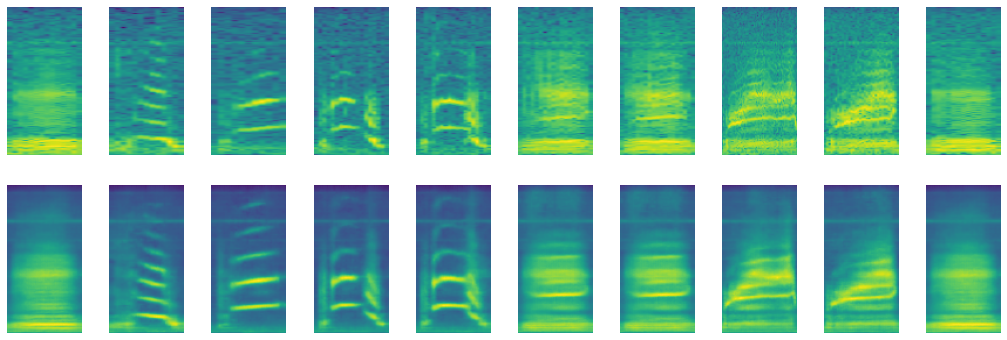

In [53]:
# 복원이 잘됐는지?

recs = vae.vae.predict(x_data)
print(recs.shape, x_data.shape)

plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_data[i, :, :, 0])
    plt.axis('off')
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(recs[i, :, :, 0])
    plt.axis('off')

In [54]:
def plot_project(data_2d, c_lenth=1, save=None):

    x = data_2d[:,0]
    y = data_2d[:,1]

    if type(c_lenth)==int:
        fig=plt.figure(figsize=(6,6))
        c = plt.scatter(x, y, marker='.', c='black', alpha=0.4)      
    else:
        fig=plt.figure(figsize=(8,6))
        c = plt.scatter(x, y, c=c_lenth, cmap='jet', marker='.')
        plt.colorbar(c)
    if save!=None:
        plt.savefig(save)
    plt.show()

In [55]:
mu, sigma, z = vae.encoder.predict(x_data)
z.shape 

24/24 [==============================] - 0s 7ms/step


(765, 2)

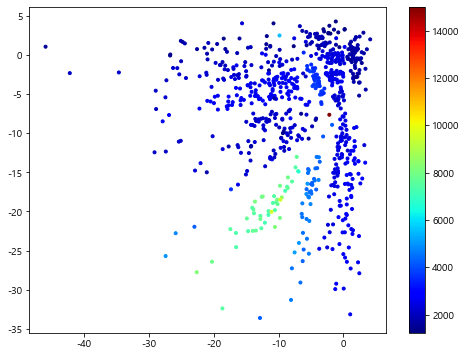

In [56]:
plot_project(z, length)

In [57]:
grid_x = np.linspace(-5, 5, 11)
grid_y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(grid_x, grid_y)

1/1 [==============================] - 0s 13ms/step


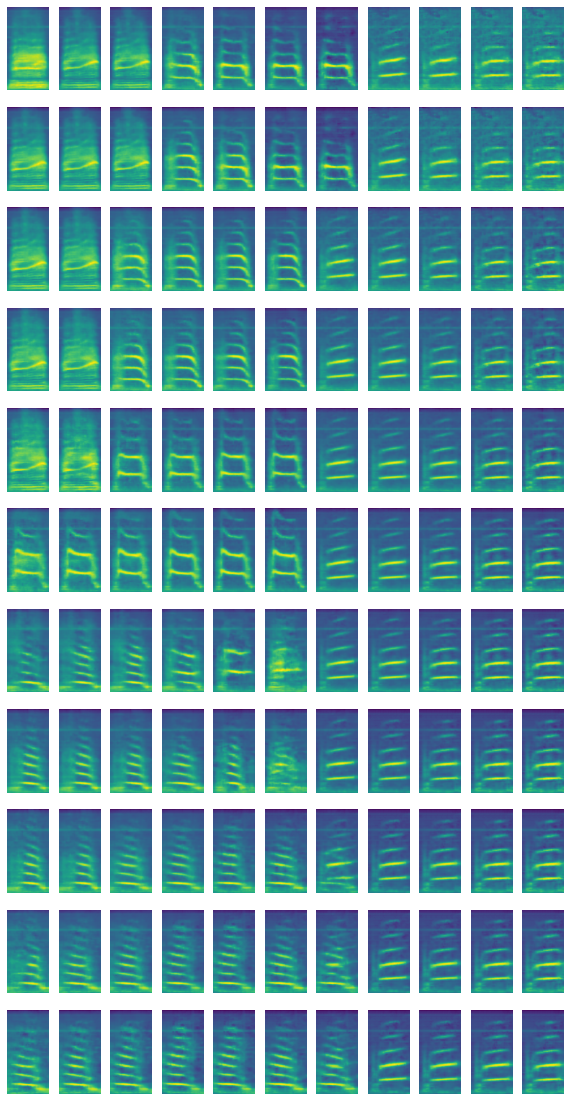

In [58]:
plt.figure(figsize=(10,20))
i=0
for xx, yy in zip(X, Y):
  for x, y in zip(xx, yy):
    z_sample = np.array([[x, y]])
    recs = vae.decoder.predict(z_sample)
    rec = recs[0,:,:,0]
    i+=1
    plt.subplot(11,11,i)
    plt.imshow(rec)
    plt.axis('off')